# Classifying Medical Images

As we saw with the previous examples, using knowledge transfer can be valuable when trying to build classifiers with very little data. How well does this approach work with medical images? In principle it would work the same. The ideal case would be to take a pre-trained model that has been trained on medical images and then use it on our new medical image problem. 

However, most of the pretrained models that I'm familiar with have been trained on **natural images**, photos of cats and dogs, cars and trucks, etc. On the one hand, edges are edges and so there should be a lot of similarity between a model trained on natural images and medical image tasks. On the other hand, there clearly are differences, one of the most obvious being that radiological images are primarily grayscale. What are some choices to address this?

In answer to the on-line question

>I want to train a dataset of black and white (no greyscale either)....[W]hat do I have to change in the model?

One repsondant said, 
>Easiest solution is to repeat your grayscale data x3 along the channel axis. You could weight that differently for the different channels or if you’re adventurous try to stick a 3 filter convolutional layer that you train between the grayscale data and the pretrained model (make sure the pretrained weights are frozen before training).
>
Alternatively you can take the sum of the weights of the first convolutional layer kernel along the input channel axis and create a new model that expects one channel input and load those weights into the first layer. This will reduce the number of operations you perform. ([http://forums.fast.ai/](http://forums.fast.ai/t/black-and-white-images-on-vgg16/2479))

We took the first approach and converted DICOM images to RGB jpegs by repeating the grayscale information in each channel.

Another challenge is dynamic range. CT images have a dynamic range on the order of 4000. A JPEG has a dynamic range of 256.

Here is a straight translation of the previous tutorial to classify an image as coming from an MRI neck, CT neck, or CT chest study.

## Look at your Data!

In [36]:
from IPython.display import Image, display
import glob
import random
import matplotlib.pyplot as plt
train_data_dir = '/home/jovyan/DATA/Radiology/demo/train'
validation_data_dir = '/home/jovyan/DATA/Radiology/demo/validation'
mr_neck = glob.glob("/home/jovyan/DATA/Radiology/demo/train/mr_neck/*.jpg")
ct_neck = glob.glob("/home/jovyan/DATA/Radiology/demo/train/ct_neck/*.jpg")
ct_chest = glob.glob("/home/jovyan/DATA/Radiology/demo/train/ct_chest/*.jpg")
random.shuffle(mr_neck)
random.shuffle(ct_neck)
random.shuffle(ct_chest)
mr_neck = iter(mr_neck)
ct_neck = iter(ct_neck)
ct_chest = iter(ct_chest)

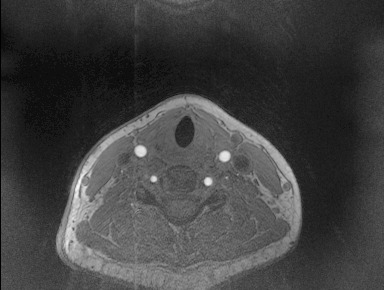

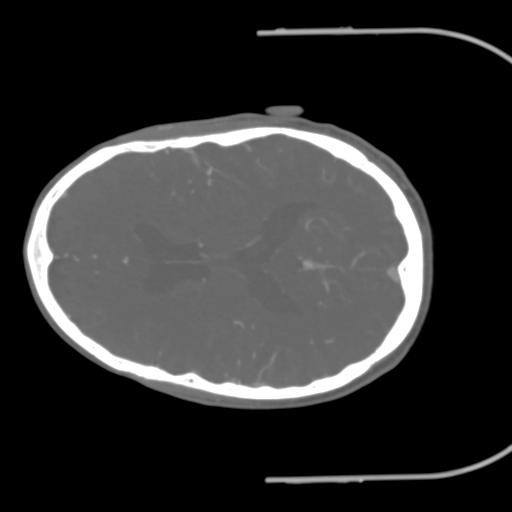

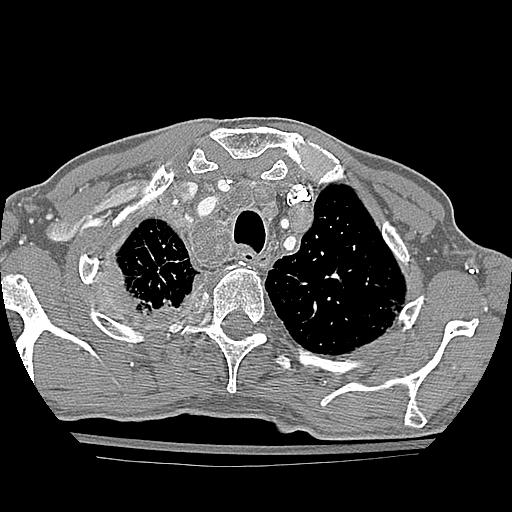

(None, None, None)

In [40]:
mr = next(mr_neck)
ctn = next(ct_neck)
ctc = next(ct_chest)
display(Image(mr, width=128)), display(Image(ctn, width=128)), display(Image(ctc, width=128))

In [41]:

import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

# dimensions of our images.
img_width, img_height = 150, 150

top_model_weights_path = 'radiology_bottleneck_fc_model.h5'
train_data_dir = '/home/jovyan/DATA/Radiology/demo/train'
validation_data_dir = '/home/jovyan/DATA/Radiology/demo/validation'
nb_train_samples = 1500
nb_validation_samples = 500
epochs = 50
batch_size = 25


def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save(open('radiology_bottleneck_features_train.npy', 'wb'), ####
            bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save(open('radiology_bottleneck_features_validation.npy', 'wb'), ####
            bottleneck_features_validation)


def train_top_model():
    train_data = np.load(open('radiology_bottleneck_features_train.npy', 'rb')) ####
    
    train_labels = np.array(
        [0] * int(nb_train_samples / 2) + [1] * int(nb_train_samples / 2)) ####
    #return train_data, train_labels
    

    validation_data = np.load(open('radiology_bottleneck_features_validation.npy', 'rb')) ####
    validation_labels = np.array(
        [0] * int(len(validation_data) / 2) + [1] * int(len(validation_data) / 2)) ####
    #return validation_data, validation_labels
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)


save_bottlebeck_features()
train_top_model()


Found 4500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Train on 1500 samples, validate on 500 samples
Epoch 1/50
1500/1500 [==============================] - 3s 2ms/step - loss: 1.5076 - acc: 0.5200 - val_loss: 0.6532 - val_acc: 0.5760
Epoch 2/50
1500/1500 [==============================] - 1s 705us/step - loss: 0.6926 - acc: 0.5780 - val_loss: 0.7131 - val_acc: 0.5520
Epoch 3/50
1500/1500 [==============================] - 1s 642us/step - loss: 0.6834 - acc: 0.5947 - val_loss: 0.6194 - val_acc: 0.6580
Epoch 4/50
1500/1500 [==============================] - 1s 628us/step - loss: 0.6190 - acc: 0.6667 - val_loss: 0.5938 - val_acc: 0.6580
Epoch 5/50
1500/1500 [==============================] - 1s 628us/step - loss: 0.6151 - acc: 0.6487 - val_loss: 0.6434 - val_acc: 0.5960
Epoch 6/50
1500/1500 [==============================] - 1s 627us/step - loss: 0.5702 - acc: 0.6933 - val_loss: 0.7010 - val_acc: 0.6200
Epoch 7/50
1500/1500 [==============================] -

## Working with ImageDataGenerator

In [ ]:
''',
                                 rotation_range=90,
                                 width_shift_range=0.3,
                                 height_shift_range=0.3,
                                 horizontal_flip=True,
                                 vertical_flip=True
'''